# Fast Food Marketing Campaign A/B Test

A fast-food chain plans to add a new item to its menu. However, they are still undecided between three possible marketing campaigns for promoting the new product. In order to determine which promotion has the greatest effect on sales, the new item is introduced at locations in several randomly selected markets. A different promotion is used at each location, and the weekly sales of the new item are recorded for the first four weeks.

[Fast Food Data Set](https://www.kaggle.com/datasets/chebotinaa/fast-food-marketing-campaign-ab-test)

## 0. Data overview

In order to define steps for analysis, we need to get familiar with the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
from statsmodels.graphics.gofplots import qqplot
import scikit_posthocs as sp
from sklearn.utils import resample
from scipy.stats import chisquare

In [2]:
df = pd.read_csv("WA_Marketing-Campaign.csv")

In [3]:
df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


In [4]:
print(df.dtypes, end="\n\n")
print(
    "Dataset has:",
    len(df),
    "records,",
    df.isnull().sum().sum(),
    "nulls,",
    df.duplicated().sum(),
    "duplicates.",
)

MarketID              int64
MarketSize           object
LocationID            int64
AgeOfStore            int64
Promotion             int64
week                  int64
SalesInThousands    float64
dtype: object

Dataset has: 548 records, 0 nulls, 0 duplicates.


The variables are:
- MarketID: unique identifier for market
- MarketSize: size of market area by sales
- LocationID: unique identifier for store location
- AgeOfStore: age of store in years
- Promotion: one of three promotions that were tested
- week: one of four weeks when the promotions were run
- SalesInThousands: sales amount for a specific LocationID, Promotion, and week

This dataset has sales for 4 weeks during 3 different marketing campaigns with several levels of possible grouping.

Some aggregation will be done, to see how data looks like.

In [5]:
df_grouped = (
    df.groupby(["MarketSize", "Promotion"])
    .agg(
        {
            "LocationID": "count",
            "AgeOfStore": "mean",
            "SalesInThousands": ["sum", "mean"],
        }
    )
    .reset_index()
)

df_grouped.columns = [
    "MarketSize",
    "Promotion",
    "LocationID_count",
    "AgeOfStore_mean",
    "Sales_total",
    "Sales_mean",
]

df_grouped["LocationID_count"] = df_grouped["LocationID_count"] / 4
df_grouped

,MarketSize,Promotion,LocationID_count,AgeOfStore_mean,Sales_total,Sales_mean
0,Large,1,14.0,5.857143,4213.21,75.235893
1,Large,2,16.0,8.437500,3860.61,60.322031
2,Large,3,12.0,6.916667,3705.79,77.203958
3,Medium,1,24.0,9.125000,4576.57,47.672604
4,Medium,2,27.0,7.481481,4224.35,39.114352
5,Medium,3,29.0,9.724138,5274.39,45.468879
6,Small,1,5.0,11.000000,1203.25,60.162500
7,Small,2,4.0,9.500000,812.97,50.810625
8,Small,3,6.0,11.500000,1428.34,59.514167


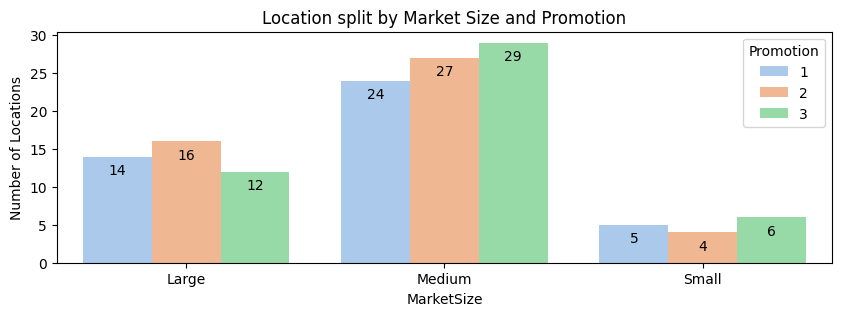

Sample sizes by promotion [43. 47. 47.]


In [6]:
plt.figure(figsize=(10, 3))
barplot = sns.barplot(
    data=df_grouped,
    y="LocationID_count",
    hue="Promotion",
    x="MarketSize",
    palette=sns.color_palette("pastel", n_colors=3),
)

barplot.set_ylabel("Number of Locations")

for container in barplot.containers:
    barplot.bar_label(container, fmt="%d", padding=-15)

barplot.set_title("Location split by Market Size and Promotion")

plt.show()
print(
    "Sample sizes by promotion",
    df_grouped.groupby("Promotion")["LocationID_count"].sum().values,
)

- Locations were not assigned to different **Promotions** by equal proportions by **total number** and by **Market Size**. E.g. Small **Market Size** has 4 Locations in **Promotion 2** and 6 Locations in **Promotion 3** which is 50 % difference, however it is not big difference in absolute values.
- Average **Age of Location** differs between **Market Size** groups having on average oldest **Locations** in Small Markets, folowed by Medium and Large. 

SRM for sample proportion will be checked with Chi-square test. The chi-square test tests the null hypothesis that the categorical data has the given frequencies, in this case: 50-50. As **Promotion 2** and **Promotion 3** has same saple size, it will be compare the sizes of 43 and 47.

$H_0:$ Assignement to Promotions has equal frequencies.

$H_1:$ Assignement to Promotions has no equal frequencies.

In [7]:
sample = [43, 47]
chi, p = chisquare(sample)
print(
    "Chi-square results for data before clean up Chi:",
    chi.round(4),
    "p-value:",
    p.round(4),
)

Chi-square results for data before clean up Chi: 0.1778 p-value: 0.6733


p-values > 0.05 implies that hypothesis about equal frequencies in sample is failed to be rejected. 

Data will be summarized by **Promotion**.

In [8]:
df_grouped2 = df.groupby("Promotion").agg(
    {"LocationID": "count", "AgeOfStore": "mean", "SalesInThousands": ["sum", "mean"]}
)
df_grouped2.columns = [
    "LocationID_count",
    "AgeOfStore_mean",
    "Sales_total",
    "Sales_mean",
]
df_grouped2

,LocationID_count,AgeOfStore_mean,Sales_total,Sales_mean
Promotion,,,,
1,172,8.279070,9993.03,58.099012
2,188,7.978723,8897.93,47.329415
3,188,9.234043,10408.52,55.364468


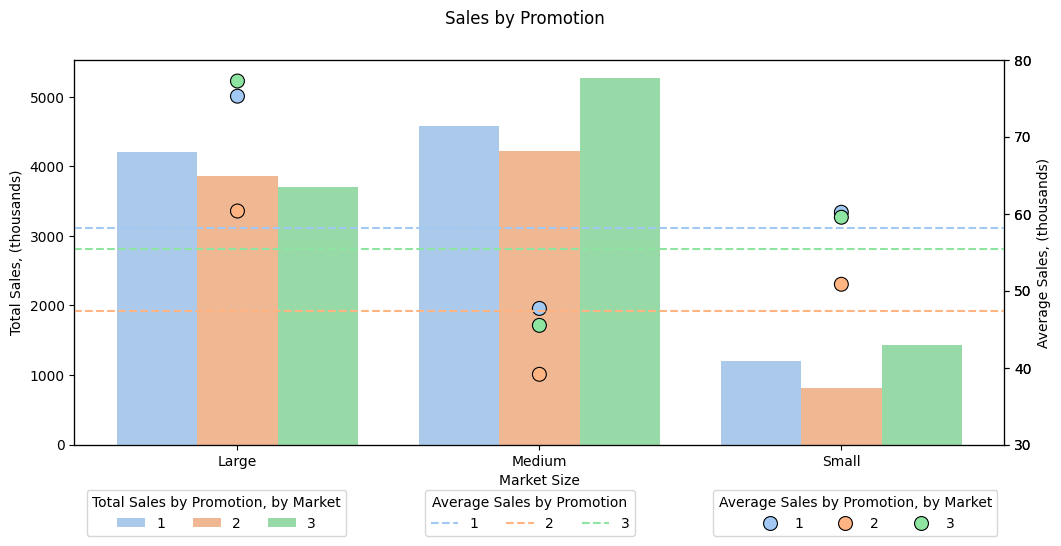

In [9]:
fig, ax1 = plt.subplots(figsize=(12, 5))

colors = sns.color_palette("pastel", n_colors=3)
ax2 = ax1.twinx()
ax3 = ax1.twinx()

sns.barplot(
    data=df_grouped,
    x="MarketSize",
    y="Sales_total",
    hue="Promotion",
    palette=colors,
    ax=ax1,
)

sns.scatterplot(
    data=df_grouped,
    x="MarketSize",
    y="Sales_mean",
    hue="Promotion",
    palette=colors,
    ax=ax2,
    s=100,
    marker="o",
    edgecolor="black",
)

for i in range(3):
    ax3.axhline(
        y=df_grouped2.iloc[i]["Sales_mean"],
        color=colors[i],
        linestyle="--",
        linewidth=1.5,
        label=i + 1,
    )

ax1.set_ylabel("Total Sales, (thousands)")
ax1.set_xlabel("Market Size")
ax2.set_ylabel("Average Sales, (thousands)")
ax2.set_ylim(30, 80)
ax3.set_ylim(30, 80)
ax1.legend(
    title="Total Sales by Promotion, by Market", bbox_to_anchor=(0.3, -0.1), ncol=3
)
ax2.legend(
    title="Average Sales by Promotion, by Market", bbox_to_anchor=(1, -0.1), ncol=3
)
ax3.legend(title="Average Sales by Promotion", bbox_to_anchor=(0.61, -0.1), ncol=3)
fig.suptitle("Sales by Promotion")

plt.show()

- Total sales are highest for **Promotion** no. 3, folowed by 1, and 2. However because of unequal **Location** split - average sales are highest for **Promotion** no 1, followed by 3 and 2.
- Similar tendencies are when looking to each **Market Size** separately. Highest total sales of one **Promotion** are causes by higher number of **Locations** assigned to that **Promotion**. 

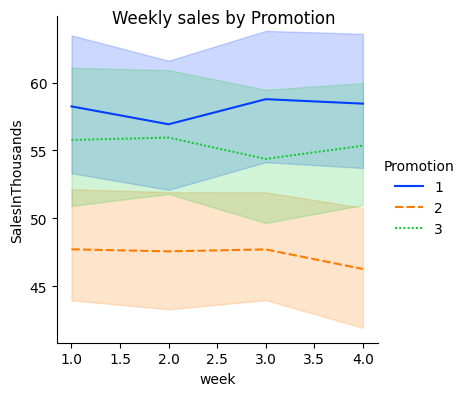

In [10]:
sns.relplot(
    data=df,
    x="week",
    y="SalesInThousands",
    hue="Promotion",
    style="Promotion",
    kind="line",
    dashes=True,
    palette=sns.color_palette("bright", n_colors=3),
    hue_order=[1, 2, 3],
    height=4,
)
plt.suptitle("Weekly sales by Promotion")
plt.show()

In [11]:
fig = px.line(
    df,
    x="week",
    y="SalesInThousands",
    facet_col="MarketSize",
    color="Promotion",
    category_orders={
        "Promotion": [1, 2, 3],
        "MarketSize": ["Large", "Medium", "Small"],
    },
)

fig.update_layout(
    title={
        "text": "Weekly sales by Promotion and LocationID",
        "x": 0.5,
        "xanchor": "center",
    }
)

fig.show()

- Average weekly sale by **Promotion** show some deviations between weeks, however they are not extreme.
- Some confidence intervals overlap, suggesting that there may be no significant difference between **Promotions**. This will have to be tested.
- Weekly sales by each **Promotion** and **LocationID** doesn't show any significant deviations from average tendencies. 

### Limitations

- Not equal assignement to **Promotion** groups.
- No base line for sales without **Promotion**. This allows only to compare if there is difference in performance of **Promotions**. However it is not clear if **Promotion** itself makes sence e.g. if there is difference between **Promotion** and **no Promotion**.

## 1. Goal

Evaluate A/B testing results and decide which marketing strategy works the best.

## 2. Target Metric

Sales for each **Promotion**.

## 3. Analysis

Analysis is divided into folowing steps:
1. Hypothesis
2. Asumptions
3. Assumption Tests
4. Hypothesis Testing

### 3.1 Hypothesis

When comparing the means of three groups in an A/B test context, typically ANOVA (Analysis of Variance) test is used. One-way ANOVA is suitable for  comparing the differences among groups in terms of a single factor, this case - **Promotion**.

ANOVA is used to test whether there are statistically significant differences between the means of three or more independent groups in terms of the target metric. This case - Sales.

If the ANOVA test is significant, post hoc tests can be performed further (like Tukey's HSD test) to identify which specific groups differ from each other.

Having this in mind, hypethesis is formulated as follows:

$H_0: \mu_{Promotion 1} = \mu_{Promotion 2} = \mu_{Promotion 3} \\$ 
There is no statistically significant difference between Sales of he Promotions

$H_1: \mu_{Promotion 1} \neq \mu_{Promotion 2} \neq \mu_{Promotion 3}\\$ 
There is statistically significant difference between Sales of he Promotions

where $\mu$ is average sales of respective **Promotion**

### 3.2 Assumptions

Before using ANOVA, it is important to check that following assumptions are met:

- Independence: The observations in each group must be independent of each other. 
- Normality: The data in each group should follow a normal distribution. This will be tested using the Shapiro-Wilk tests.
- Homogeneity of Variances: The variances across the groups should be equal. This can be tested using Levene's Test.

### 3.3 Assumption Tests

#### Independence

- Each **LocationID** was assigned to separate **Promotion**. No **LocationID** participates in more than one **Promotion**.
- Each **Promotion** has not exact, but relatively similar group size (43-47 LocationID's).

It will be checked if there is **Sales** correlation between weeks. 
- If no or week correlation found, weekly data will be used as observation.
- If correlation is strong - aggregated **Sales** by **LocationID** will be used. 

In [12]:
df_weekly = df.pivot_table(
    index="LocationID", columns="week", values="SalesInThousands"
)
df_weekly.corr()

week,1,2,3,4
week,,,,
1,1.000000,0.899667,0.918814,0.916938
2,0.899667,1.000000,0.880008,0.935636
3,0.918814,0.880008,1.000000,0.886455
4,0.916938,0.935636,0.886455,1.000000


Correlation coeficient is higher than 0.8 what indicates strong correlation between weekly sales. There for dataset will be agregated to have total sales for each **LocationID** which with condition that each **LocationID** belongs to different **Promotion** will be treated as independent.

In [13]:
df_agg = (
    df.groupby("LocationID")
    .agg(
        {
            "SalesInThousands": "sum",
            "MarketSize": "first",
            "AgeOfStore": "first",
            "MarketID": "first",
            "Promotion": "first",
        }
    )
    .reset_index()
)

df_agg

,LocationID,SalesInThousands,MarketSize,AgeOfStore,MarketID,Promotion
0,1,137.68,Medium,4,1,3
1,2,118.18,Medium,5,1,2
2,3,162.72,Medium,12,1,1
3,4,134.83,Medium,1,1,2
4,5,116.01,Medium,10,1,2
...,...,...,...,...,...,...
132,916,191.04,Large,7,10,2
133,917,211.87,Large,14,10,3
134,918,223.90,Large,6,10,1
135,919,244.40,Large,2,10,1


#### Normality check

Shapiro-Wilk test will be used to check Normality.

$H_0:$ The normality assumption is met.

$H_1:$ The normality assumption is not met.

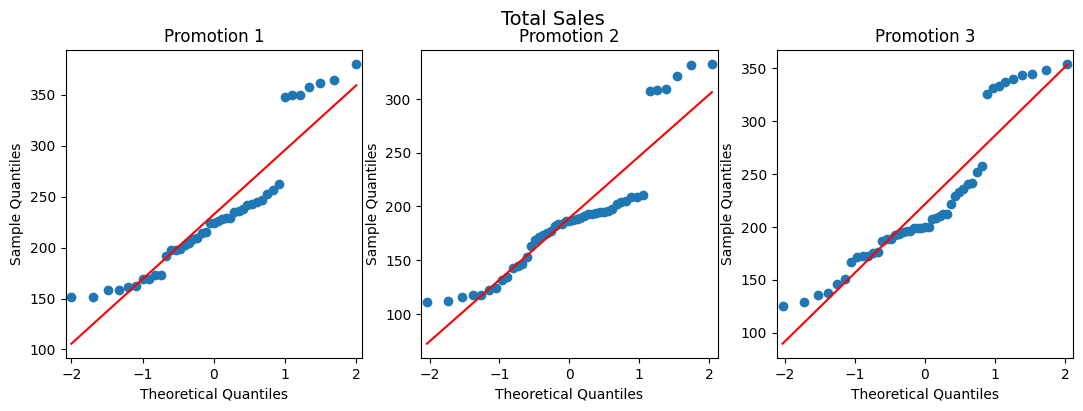

Shapiro-Wilk Test (Normality check):
Promotion 1 p-value: 0.0002
Promotion 2 p-value: 0.0
Promotion 3 p-value: 0.0001


In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 4))
qqplot(df_agg.loc[df_agg["Promotion"] == 1, "SalesInThousands"], line="s", ax=ax1)
qqplot(df_agg.loc[df_agg["Promotion"] == 2, "SalesInThousands"], line="s", ax=ax2)
qqplot(df_agg.loc[df_agg["Promotion"] == 3, "SalesInThousands"], line="s", ax=ax3)

ax1.set_title("Promotion 1")
ax2.set_title("Promotion 2")
ax3.set_title("Promotion 3")
fig.suptitle("Total Sales", size=14)
plt.show()

print("Shapiro-Wilk Test (Normality check):")
for i in range(3):
    pvalue = stats.shapiro(
        df_agg.loc[df_agg["Promotion"] == i + 1, "SalesInThousands"]
    )[1].round(4)
    print("Promotion", i + 1, "p-value:", pvalue)

Shapiro-Wilk test's p-value is < 0.05 and hypothesis that **Sales are Normally distributed** is rejected. 

#### Homogeneity of Variances

Levene's Test will be used to check Homogeneity of Variances.

$H_0:$ The variance homogeneity is met.

$H_1:$ The variance homogeneity is not met.

In [15]:
test_stat, pvalue = stats.levene(
    df_agg.loc[df_agg["Promotion"] == 1, "SalesInThousands"],
    df_agg.loc[df_agg["Promotion"] == 2, "SalesInThousands"],
    df_agg.loc[df_agg["Promotion"] == 3, "SalesInThousands"],
)

print("Test Stat =", test_stat, "p-value =", pvalue.round(4))

Test Stat = 0.4681608444016787 p-value = 0.6272


Levene's test's p-value is > 0.05 and hypothesis that **Variance homogenity is met** is failed to be rejected. 

### 3.4. Hypothesis testing

- Independence - met
- Normality - not met
- Homogeneity of Variances - met

#### Kruskal-Wallis Test


As Normality assumption is not met, non parametric Kruskal-Wallis test will be performed instead of ANOVA test. 

The Kruskal-Wallis test is a non-parametric statistical test used to compare three or more independent groups to determine if there are statistically significant differences in their central tendencies (usually **median** values).

$H_0:$ 3 groups sales medians are equal.

$H_1:$ 3 groups sales medians are not equal.

In [16]:
kruskal_result = stats.kruskal(
    df_agg.loc[df_agg["Promotion"] == 1, "SalesInThousands"],
    df_agg.loc[df_agg["Promotion"] == 2, "SalesInThousands"],
    df_agg.loc[df_agg["Promotion"] == 3, "SalesInThousands"],
)

print("Kruskal-Wallis test result p-value:", kruskal_result.pvalue.round(4))

Kruskal-Wallis test result p-value: 0.0002


Kruskal-Wallis' test's p-value is < 0.05 and hypothesis that **3 groups sales medians are equal** is rejected. 

#### Dunn's Test

Dunn's test is a non-parametric post hoc test used following the Kruskal-Wallis test to identify which specific groups have significant differences in their median values. While the Kruskal-Wallis test only tells us if there is a significant difference among groups, Dunn's test provides a way to pinpoint where those differences lie, comparing all pairs of groups.

$H_0:$ Sales medians ar eaqual.

$H_1:$ Sales medians ar not eaqual.

In [17]:
if kruskal_result.pvalue < 0.05:
    dunn_result = sp.posthoc_dunn(
        df_agg,
        val_col="SalesInThousands",
        group_col="Promotion",
        p_adjust="bonferroni",
        sort=True,
    )
    print("Dunn's test pairwise comparison p-values:\n", dunn_result)

Dunn's test pairwise comparison p-values:
           1         2         3
1  1.000000  0.000170  0.688422
2  0.000170  1.000000  0.011573
3  0.688422  0.011573  1.000000


Dunn's test's p-value is < 0.05 and hypothesis that **Sales medians are equal** is rejected for:
- **Promotion 1** and **Promotion 2** pair.
- **Promotion 3** and **Promotion 2** pair.

Meaning that there is significant difference between **Sales** in these pairs.

Dunn's test's p-value is > 0.05 and hypothesis that **Sales medians are equal** is failed to be rejected for:
- **Promotion 1** and **Promotion 3**. 

This means that there is no significant difference between **Sales** in these **Promotions**. 

#### Confidence Intervals

Comparison between **Promotion** groups was done using non-parametric test for medians. There for - estimated treatment effect and confidens intervals has to be calculated for median. As **Sales** in dataset were not distributed Normally, the only way to calculate this is using **Bootstrap** method.

In [18]:
def hodges_lehmann_ci(group_a, group_b, n_iterations=1000, ci=95):
    """Calculate Hodges-Lehmann estimator and its confidence interval using bootstrapping."""
    pairwise_diffs = [a - b for a in group_a for b in group_b]
    hl_estimate = np.median(pairwise_diffs)
    bootstrapped_diffs = []

    for _ in range(n_iterations):
        sample_a = resample(group_a)
        sample_b = resample(group_b)
        sample_diffs = [a - b for a in sample_a for b in sample_b]
        bootstrapped_diffs.append(np.median(sample_diffs))

    lower = np.percentile(bootstrapped_diffs, (100 - ci) / 2)
    upper = np.percentile(bootstrapped_diffs, 100 - (100 - ci) / 2)
    return hl_estimate, lower, upper, bootstrapped_diffs


hl_1_2, lower_1_2, upper_1_2, dist_1_2 = hodges_lehmann_ci(
    df_agg.loc[df_agg["Promotion"] == 1, "SalesInThousands"],
    df_agg.loc[df_agg["Promotion"] == 2, "SalesInThousands"],
)
hl_1_3, lower_1_3, upper_1_3, dist_1_3 = hodges_lehmann_ci(
    df_agg.loc[df_agg["Promotion"] == 1, "SalesInThousands"],
    df_agg.loc[df_agg["Promotion"] == 3, "SalesInThousands"],
)
hl_2_3, lower_2_3, upper_2_3, dist_2_3 = hodges_lehmann_ci(
    df_agg.loc[df_agg["Promotion"] == 2, "SalesInThousands"],
    df_agg.loc[df_agg["Promotion"] == 3, "SalesInThousands"],
)

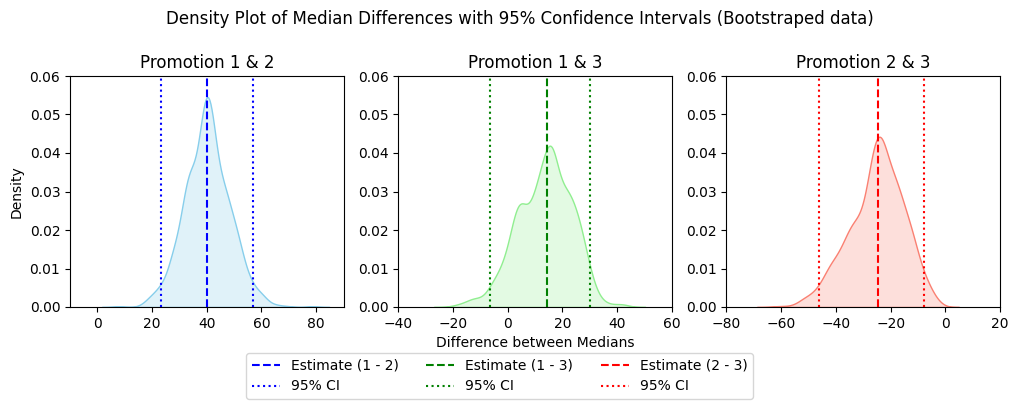

Promotion 1 - Promotion 2 Hodges-Lehmann estimate: 40.06 and 95% CI 23.3748 - 57.07
Promotion 1 - Promotion 3 Hodges-Lehmann estimate: 14.31 and 95% CI -6.4025 - 30.091
Promotion 2 - Promotion 3 Hodges-Lehmann estimate: -24.56 and 95% CI -46.2075 - -7.9095


In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))

sns.kdeplot(dist_1_2, fill=True, color="skyblue", ax=ax1)
ax1.axvline(hl_1_2, color="blue", linestyle="--", label="Estimate (1 - 2)")
ax1.axvline(lower_1_2, color="blue", linestyle=":", label="95% CI")
ax1.axvline(upper_1_2, color="blue", linestyle=":")
ax1.set_ylim(0, 0.06)
ax1.set_xlim(-10, 90)

sns.kdeplot(dist_1_3, fill=True, color="lightgreen", ax=ax2)
ax2.axvline(hl_1_3, color="green", linestyle="--", label="Estimate (1 - 3)")
ax2.axvline(lower_1_3, color="green", linestyle=":", label="95% CI")
ax2.axvline(upper_1_3, color="green", linestyle=":")
ax2.set_ylim(0, 0.06)
ax2.set_xlim(-40, 60)

sns.kdeplot(dist_2_3, fill=True, color="salmon", ax=ax3)
ax3.axvline(hl_2_3, color="red", linestyle="--", label="Estimate (2 - 3)")
ax3.axvline(lower_2_3, color="red", linestyle=":", label="95% CI")
ax3.axvline(upper_2_3, color="red", linestyle=":")
ax3.set_ylim(0, 0.06)
ax3.set_xlim(-80, 20)

ax2.set_xlabel("Difference between Medians")
ax1.set_ylabel("Density")
ax2.set_ylabel("")
ax3.set_ylabel("")
ax1.set_title("Promotion 1 & 2")
ax2.set_title("Promotion 1 & 3")
ax3.set_title("Promotion 2 & 3")
fig.suptitle(
    "Density Plot of Median Differences with 95% Confidence Intervals (Bootstraped data)",
    x=0.5,
    y=1.1,
)
fig.legend(bbox_to_anchor=(0.7, -0.02), ncol=3)
plt.show()

print(
    "Promotion 1 - Promotion 2 Hodges-Lehmann estimate:",
    hl_1_2.round(4),
    "and 95% CI",
    lower_1_2.round(4),
    "-",
    upper_1_2.round(4),
)
print(
    "Promotion 1 - Promotion 3 Hodges-Lehmann estimate:",
    hl_1_3.round(4),
    "and 95% CI",
    lower_1_3.round(4),
    "-",
    upper_1_3.round(4),
)
print(
    "Promotion 2 - Promotion 3 Hodges-Lehmann estimate:",
    hl_2_3.round(4),
    "and 95% CI",
    lower_2_3.round(4),
    "-",
    upper_2_3.round(4),
)

**Promotion 1** and **Promotion 3** Confidence interval for Median difference esstimate (Treatment effect) has 0 in it, what means that there is no Statistically Significant difference between Median values for **Promotions** 1 and 3. 

There are quite heavy tails outside 95% CI. Potential reason for that could be:
- Bootstrapping relies on repeated random resampling, which can sometimes produce extreme values, especially when the underlying data distribution is skewed or has outliers. These extreme values in bootstrap samples can lead to wider confidence intervals with longer tails in the distribution.
- Non-normal distributions (especially with heavy tails or skewness) can lead to bootstrap distributions that reflect this, making confidence intervals wider than if the data were more normally distributed.
- Confidence intervals for median differences tend to be wider than for means, especially if the sample sizes are small. 
- Calculating pairwise differences between all elements in group_a and group_b means that the bootstrap distribution includes every possible combination, not just a single paired difference. This method (Hodges-Lehmann estimator via pairwise differences) often produces a wider confidence interval compared to traditional means.
- The number of bootstrap iterations can impact the stability and spread of the confidence intervals. A lower number of iterations may produce more variability, while increasing it usually stabilizes the results. However, if the underlying data is highly variable, even many bootstrap iterations will yield long tails.

## 4. Summary

- **Promotion 2** showed worst results. Both, total sales and average sales were the lowest between 3 groups.
- **Promotion 3** had highest **Total** sales. However because of inequality of assigning **LocationID's** to **Promotions** (less **LocationID's** in **Promotion 1** compared to **Promotion 3**) average sales were highest in **Promotion 1**
- A/B test results showed significant difference of **Promotion 2** from other groups. It's Median is ~40 lower than **Promotion 1**, and ~ 24 lower than **Promotion3**.
- A/B test results showed no statistically significant diffrence between **Promotion 1** and **Promotion 3** groups. Although diffrence of ~14 could be significant for business decisions.

Recomendations for decision:
- Analyze **Promotions 1** and **Promotion 3** additionaly to see if there is any kind of similarities between **Promotion** themselves what may caused similar results.
- Analyze **Promotions 1** and **Promotion 3** from Market size, store location perspective to see if this may have causes similar results, or maybe different markets react better to different promotions.
- If there is no possibility for additional analysis - **Promotion 1** can be chosen for marketing strategy as having highest sales.